In [4]:
import h5py
import numpy as np
from datetime import datetime, timezone, timedelta
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import PowerNorm
import gc

In [5]:
dataset_path = "/Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_tracks_20250714.h5"

if "ds" in vars():
    ds.close()   # type: ignore

ds = h5py.File(dataset_path, "r")
for attr in ds.attrs:
    print(f"{attr}: {ds.attrs[attr]}")

author: Mark Vodyanitskiy (mvodya@icloud.com)
created_at: 2025-07-13T14:26:08.378871
filter_rules: MIN_TOTAL_POINTS=50, MIN_MOVING_POINTS=5, MIN_MAX_SPEED=20, SPEED_MOVING_MIN=10, SPEED_SANITY_MAX=800
filtered_at: 2026-01-08T06:02:47.931391
sources_count: 27555
sources_size: 439.3Gb
tracks_built_at: 2026-01-09T17:19:14.225437
tracks_count: 11731643
tracks_rules: SPEED_MOVING_MIN=10, STOP_RADIUS_M=250.0, STOP_DWELL_SEC=1800, GAP_HARD_SEC=18000, GAP_VERY_HARD_SEC=36000, DIST_AFTER_GAP_M=150000.0, JUMP_HARD_M=250000.0, DEST_GAP_SEC=14400, DEST_DIST_M=50000.0
version: 1.0


In [6]:
QUALITY_MAX_GAP_SEC = 4 * 60 * 60
CHUNK_ROWS = 2_000_000

def find_ship_by_ship_id_chunked(ds_ships, target_ship_id: int, chunk_rows: int = 2_000_000):
    """
    Линейный поиск по ships чанками (HDF5 блочное чтение)
    Возвращает одну запись (np.void) или None.
    """
    target = np.int64(target_ship_id)
    n = ds_ships.shape[0]

    for start in tqdm(range(0, n, chunk_rows), desc="Search ship_id in ships", unit="chunk"):
        end = min(n, start + chunk_rows)
        block = ds_ships[start:end]
        m = (block["ship_id"] == target)
        if np.any(m):
            i = int(np.argmax(m))
            return block[i]
    return None


def _decode_bytes(x) -> str:
    if x is None:
        return ""
    if isinstance(x, (bytes, np.bytes_)):
        return x.decode("utf-8", errors="replace").rstrip("\x00")
    return str(x)

def _utc_date_from_ts(ts: int) -> datetime:
    return datetime.fromtimestamp(int(ts), tz=timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

def iter_position_day_paths(ds, start_ts: int, end_ts: int):
    """
    Генерит пути вида /positions/YYYY/MM/DD, которые попадают в диапазон [start_ts, end_ts]
    """
    d0 = _utc_date_from_ts(start_ts)
    d1 = _utc_date_from_ts(end_ts)
    cur = d0
    while cur <= d1:
        y = f"{cur.year:04d}"
        m = f"{cur.month:02d}"
        d = f"{cur.day:02d}"
        path = f"/positions/{y}/{m}/{d}"
        if path in ds:
            yield path
        cur += timedelta(days=1)


def pick_track_id(ds, sample_rows: int = 50_000, min_points: int = 50, max_points: int = 200) -> tuple[int, np.void]:
    """
    Быстро выбираем нормальный трек из головы таблицы tracks (без полного скана)
    Возвращает (track_id, track_row)
    """
    tracks = ds["tracks"]
    n = tracks.shape[0]
    take = min(sample_rows, n)
    sample = tracks[:take]

    # Фильтр по points_count
    pc = sample["points_count"]
    mask = (pc >= min_points) & (pc <= max_points)
    if not np.any(mask):
        # fallback: возьмем любой
        row = sample[np.argmax(sample["points_count"])]
        return int(row["track_id"]), row

    row = sample[np.argmax(sample["points_count"][mask])]
    # note: row сейчас сжат маской не нужен - возьмем напрямую по индексу
    idx = np.where(mask)[0][np.argmax(sample["points_count"][mask])]
    row = sample[idx]
    return int(row["track_id"]), row


track_id, track_row = pick_track_id(ds, sample_rows=400_000, min_points=100, max_points=480)

print("Picked track:")
print(" track_id:", track_id)
print(" ship_id:", int(track_row["ship_id"]))
print(" points_count:", int(track_row["points_count"]))
print(" start_ts:", int(track_row["start_timestamp"]), "->", datetime.fromtimestamp(int(track_row["start_timestamp"]), tz=timezone.utc))
print(" end_ts:  ", int(track_row["end_timestamp"]), "->", datetime.fromtimestamp(int(track_row["end_timestamp"]), tz=timezone.utc))
print(" start(lat,lon):", float(track_row["start_lat"]), float(track_row["start_lon"]))
print(" end(lat,lon):  ", float(track_row["end_lat"]), float(track_row["end_lon"]))

Picked track:
 track_id: 185530
 ship_id: 2319
 points_count: 480
 start_ts: 1730401003 -> 2024-10-31 18:56:43+00:00
 end_ts:   1730872397 -> 2024-11-06 05:53:17+00:00
 start(lat,lon): 31.135160446166992 131.52139282226562
 end(lat,lon):   34.49348831176758 133.68490600585938


In [7]:
def load_track_points_from_positions(
    ds,
    track_id: int,
    start_ts: int,
    end_ts: int,
    chunk_rows: int = CHUNK_ROWS,
    apply_quality_filter: bool = True,
    max_gap_sec: int = QUALITY_MAX_GAP_SEC,
):
    """
    Достает точки конкретного track_id из positions за диапазон дат трека
    Делает это проходом по нужным /positions/YYYY/MM/DD чанками

    Возвращает dict с массивами: ts, lat, lon, speed (если есть)
    """
    # Накопители
    ts_all = []
    lat_all = []
    lon_all = []
    spd_all = []

    day_paths = list(iter_position_day_paths(ds, start_ts, end_ts))
    if not day_paths:
        return None, {"reason": "no day datasets in range"}

    pbar_days = tqdm(day_paths, desc="Days", unit="day")

    for path in pbar_days:
        dset = ds[path]
        n = dset.shape[0]

        # Подсказка в прогресс-баре
        pbar_days.set_postfix_str(path.split("/positions/")[-1])

        for s in tqdm(range(0, n, chunk_rows), desc=f"Chunks {path[-10:]}", leave=False, unit="chunk"):
            e = min(s + chunk_rows, n)
            chunk = dset[s:e]

            # Быстрый отбор по track_id
            m = (chunk["track_id"] == track_id)
            if not np.any(m):
                continue

            part = chunk[m]
            ts_all.append(part["timestamp"].astype(np.int64, copy=False))
            lat_all.append(part["lat"].astype(np.float64, copy=False))
            lon_all.append(part["lon"].astype(np.float64, copy=False))
            # speed в dtype есть, но на всякий случай
            if "speed" in part.dtype.fields:
                spd_all.append(part["speed"].astype(np.int32, copy=False))

    if not ts_all:
        return None, {"reason": "track_id not found in scanned positions"}

    ts = np.concatenate(ts_all)
    lat = np.concatenate(lat_all)
    lon = np.concatenate(lon_all)
    spd = np.concatenate(spd_all) if spd_all else None

    # Сортировка по времени (на случай если точки пришли из разных чанков/дней)
    order = np.argsort(ts, kind="mergesort")
    ts = ts[order]
    lat = lat[order]
    lon = lon[order]
    if spd is not None:
        spd = spd[order]

    # Качество: максимальный разрыв между соседними точками
    info = {}
    if ts.size >= 2:
        dt = np.diff(ts)
        info["max_gap_sec"] = int(dt.max())
        info["gaps_over_limit"] = int(np.sum(dt > max_gap_sec))
    else:
        info["max_gap_sec"] = 0
        info["gaps_over_limit"] = 0

    if apply_quality_filter and info["max_gap_sec"] > max_gap_sec:
        info["reason"] = f"failed quality: max_gap_sec={info['max_gap_sec']} > {max_gap_sec}"
        return None, info

    return {"ts": ts, "lat": lat, "lon": lon, "speed": spd}, info


# Врубаемая проверка качества трека
apply_quality_filter = False
track_points, track_info = load_track_points_from_positions(
    ds,
    track_id=track_id,
    start_ts=int(track_row["start_timestamp"]),
    end_ts=int(track_row["end_timestamp"]),
    chunk_rows=CHUNK_ROWS,
    apply_quality_filter=apply_quality_filter,
    max_gap_sec=QUALITY_MAX_GAP_SEC,
)

print("Track load info:", track_info)
if track_points is not None:
    print("Loaded points:", track_points["ts"].size)
    print("Time span:", datetime.fromtimestamp(int(track_points["ts"][0]), tz=timezone.utc),
          "->", datetime.fromtimestamp(int(track_points["ts"][-1]), tz=timezone.utc))


Days: 100%|██████████| 7/7 [00:03<00:00,  1.75day/s, 2024/11/06]

Track load info: {'max_gap_sec': 34184, 'gaps_over_limit': 1}
Loaded points: 480
Time span: 2024-10-31 18:56:43+00:00 -> 2024-11-06 05:53:17+00:00


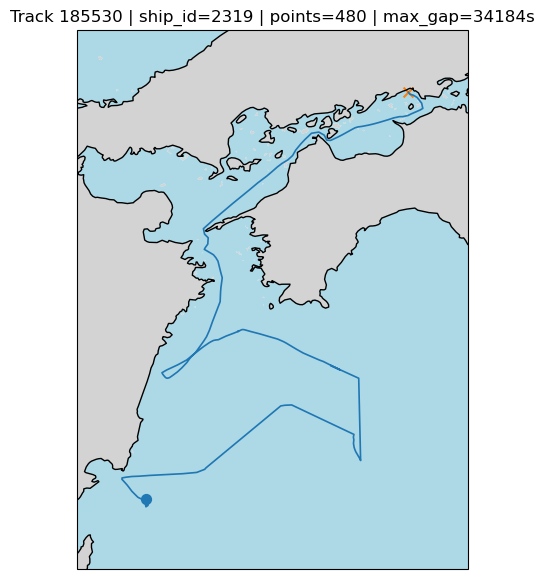

In [8]:
if track_points is None:
    print("Track did not pass quality filter or was not found:", track_info)
else:
    lats = track_points["lat"]
    lons = track_points["lon"]

    # extent с небольшим паддингом
    min_lat, max_lat = float(lats.min()), float(lats.max())
    min_lon, max_lon = float(lons.min()), float(lons.max())
    pad_lat = max(0.2, (max_lat - min_lat) * 0.15)
    pad_lon = max(0.2, (max_lon - min_lon) * 0.15)

    fig = plt.figure(figsize=(11, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([min_lon - pad_lon, max_lon + pad_lon, min_lat - pad_lat, max_lat + pad_lat], crs=ccrs.PlateCarree())

    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    ax.plot(lons, lats, linewidth=1.2, transform=ccrs.PlateCarree())

    ax.scatter([lons[0]], [lats[0]], s=50, marker="o", transform=ccrs.PlateCarree())
    ax.scatter([lons[-1]], [lats[-1]], s=50, marker="x", transform=ccrs.PlateCarree())

    ax.set_title(
        f"Track {track_id} | ship_id={int(track_row['ship_id'])} | points={lons.size} | "
        f"max_gap={track_info.get('max_gap_sec','?')}s",
        fontsize=12
    )

    plt.show()


Search ship_id in ships:   0%|          | 0/1 [00:00<?, ?chunk/s]


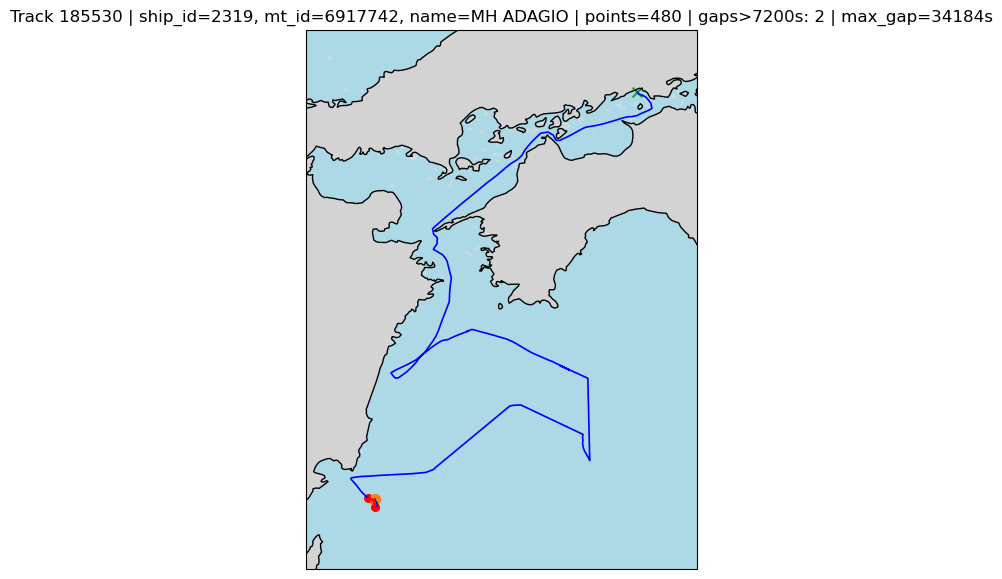

In [9]:
def plot_track_with_gaps(
    track_points: dict,
    track_id: int,
    ship_row,
    gap_sec: int = 2 * 3600,
):
    ts = track_points["ts"].astype(np.int64, copy=False)
    lat = track_points["lat"]
    lon = track_points["lon"]

    # ship labels
    ship_name = "UNKNOWN"
    mt_id = ""
    ship_id = None

    if ship_row is not None:
        ship_id = int(ship_row["ship_id"])
        ship_name = _decode_bytes(ship_row["name"])
        mt_id = _decode_bytes(ship_row["mt_id"])

    # find gaps
    if ts.size >= 2:
        dt = np.diff(ts)
        gap_idx = np.where(dt > gap_sec)[0]          # i where (i -> i+1) is a gap
        max_gap = int(dt.max())
        gaps_cnt = int(gap_idx.size)
    else:
        gap_idx = np.array([], dtype=np.int64)
        max_gap = 0
        gaps_cnt = 0

    # extent with padding
    min_lat, max_lat = float(lat.min()), float(lat.max())
    min_lon, max_lon = float(lon.min()), float(lon.max())
    pad_lat = max(0.2, (max_lat - min_lat) * 0.15)
    pad_lon = max(0.2, (max_lon - min_lon) * 0.15)

    fig = plt.figure(figsize=(11, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([min_lon - pad_lon, max_lon + pad_lon, min_lat - pad_lat, max_lat + pad_lat],
                  crs=ccrs.PlateCarree())

    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # --- plot continuous parts (split by gaps)
    # split points into segments separated by gaps
    if gap_idx.size:
        split_points = gap_idx + 1
        segments = np.split(np.arange(ts.size), split_points)
    else:
        segments = [np.arange(ts.size)]

    # draw continuous polylines
    for seg in segments:
        if seg.size >= 2:
            ax.plot(lon[seg], lat[seg], linewidth=1.2, color="blue", transform=ccrs.PlateCarree())
        elif seg.size == 1:
            ax.scatter([lon[seg[0]]], [lat[seg[0]]], s=8, transform=ccrs.PlateCarree())

    # --- draw gaps in RED (connect last of prev to first of next)
    if gap_idx.size:
        for i in gap_idx:
            j = i + 1
            ax.plot([lon[i], lon[j]], [lat[i], lat[j]],
                    linewidth=2.0, linestyle="--",
                    color="red", transform=ccrs.PlateCarree())
            ax.scatter([lon[i], lon[j]], [lat[i], lat[j]],
                       s=30, color="red", transform=ccrs.PlateCarree())

    # start/end
    ax.scatter([lon[0]], [lat[0]], s=50, marker="o", transform=ccrs.PlateCarree())
    ax.scatter([lon[-1]], [lat[-1]], s=50, marker="x", transform=ccrs.PlateCarree())

    # title with ship name
    ship_part = f"ship_id={ship_id}" if ship_id is not None else "ship_id=?"
    if mt_id:
        ship_part += f", mt_id={mt_id}"
    if ship_name:
        ship_part += f", name={ship_name}"

    ax.set_title(
        f"Track {track_id} | {ship_part} | points={ts.size} | gaps>{gap_sec}s: {gaps_cnt} | max_gap={max_gap}s",
        fontsize=12
    )
    plt.show()


ships = ds["ships"]

ship_row = find_ship_by_ship_id_chunked(ships, int(track_row["ship_id"]), chunk_rows=2_000_000)

gap_sec = 2 * 3600

if track_points is None:
    print("No track_points to plot (quality filter or not found).")
else:
    plot_track_with_gaps(
        track_points=track_points,
        track_id=int(track_id),
        ship_row=ship_row,
        gap_sec=gap_sec,
    )

In [10]:
def build_start_end_heatmaps_from_tracks(
    ds_tracks,
    extent,                 # (min_lon, max_lon, min_lat, max_lat)
    bins=(400, 300),        # (nx, ny)
    chunk_rows=2_000_000,
    quality_max_gap_sec=None,  # 40*60, или None чтобы не фильтровать
    min_points=None,           # 10 или 50, или None
):
    """
    Строит 3 хэтмапа:
      - heat_start: по (start_lon, start_lat)
      - heat_end:   по (end_lon, end_lat)
      - heat_both:  start + end
    За один проход по tracks чанками

    Фильтры:
      - quality_max_gap_sec: если задан, оставляем треки с (end_ts - start_ts) <= quality_max_gap_sec
        (Это суррогат качества по tracks; точная проверка разрывов >40 мин возможна только по positions)
      - min_points: если задан, points_count >= min_points
    """
    min_lon, max_lon, min_lat, max_lat = map(float, extent)
    nx, ny = int(bins[0]), int(bins[1])

    # Ребра для гистограммы
    x_edges = np.linspace(min_lon, max_lon, nx + 1, dtype=np.float64)
    y_edges = np.linspace(min_lat, max_lat, ny + 1, dtype=np.float64)

    heat_start = np.zeros((ny, nx), dtype=np.uint32)
    heat_end   = np.zeros((ny, nx), dtype=np.uint32)

    n = ds_tracks.shape[0]
    for start in tqdm(range(0, n, chunk_rows), desc="Scan tracks", unit="chunk"):
        end = min(n, start + chunk_rows)
        block = ds_tracks[start:end]

        # ---- фильтры на уровне tracks (быстрые)
        m = np.ones(block.shape[0], dtype=bool)

        if min_points is not None:
            m &= (block["points_count"] >= int(min_points))

        if quality_max_gap_sec is not None:
            # суррогат качества по длительности трека
            # (точные "дыры между точками" - только в positions)
            dur = (block["end_timestamp"].astype(np.int64) - block["start_timestamp"].astype(np.int64))
            m &= (dur <= int(quality_max_gap_sec))

        if not np.any(m):
            continue

        b = block[m]

        # ---- START
        xs = b["start_lon"].astype(np.float64, copy=False)
        ys = b["start_lat"].astype(np.float64, copy=False)

        # маска внутри экстента (и от NaN)
        ms = np.isfinite(xs) & np.isfinite(ys) & (xs >= min_lon) & (xs <= max_lon) & (ys >= min_lat) & (ys <= max_lat)
        if np.any(ms):
            hs, _, _ = np.histogram2d(
                ys[ms], xs[ms],
                bins=(y_edges, x_edges)
            )
            heat_start += hs.astype(np.uint32)

        # ---- END
        xe = b["end_lon"].astype(np.float64, copy=False)
        ye = b["end_lat"].astype(np.float64, copy=False)

        me = np.isfinite(xe) & np.isfinite(ye) & (xe >= min_lon) & (xe <= max_lon) & (ye >= min_lat) & (ye <= max_lat)
        if np.any(me):
            he, _, _ = np.histogram2d(
                ye[me], xe[me],
                bins=(y_edges, x_edges)
            )
            heat_end += he.astype(np.uint32)

    heat_both = heat_start + heat_end
    return (heat_start, heat_end, heat_both, x_edges, y_edges)


tracks = ds["tracks"]

extent = (120.0, 148.0, 25.0, 45.0)

bins = (100, 50)          # (nx, ny)
chunk_rows = 2_000_000
quality_max_gap_sec = None # например 40*60 если хочешь быстрый суррогат-фильтр по длительности
min_points = None          # например 10/50

heat_start, heat_end, heat_both, x_edges, y_edges = build_start_end_heatmaps_from_tracks(
    tracks,
    extent=extent,
    bins=bins,
    chunk_rows=chunk_rows,
    quality_max_gap_sec=quality_max_gap_sec,
    min_points=min_points,
)

print("extent:", extent)
print("heat_start sum:", int(heat_start.sum()), "heat_end sum:", int(heat_end.sum()), "heat_both sum:", int(heat_both.sum()))

Scan tracks: 100%|██████████| 6/6 [00:03<00:00,  1.85chunk/s]

extent: (120.0, 148.0, 25.0, 45.0)
heat_start sum: 4116574 heat_end sum: 4115829 heat_both sum: 8232403


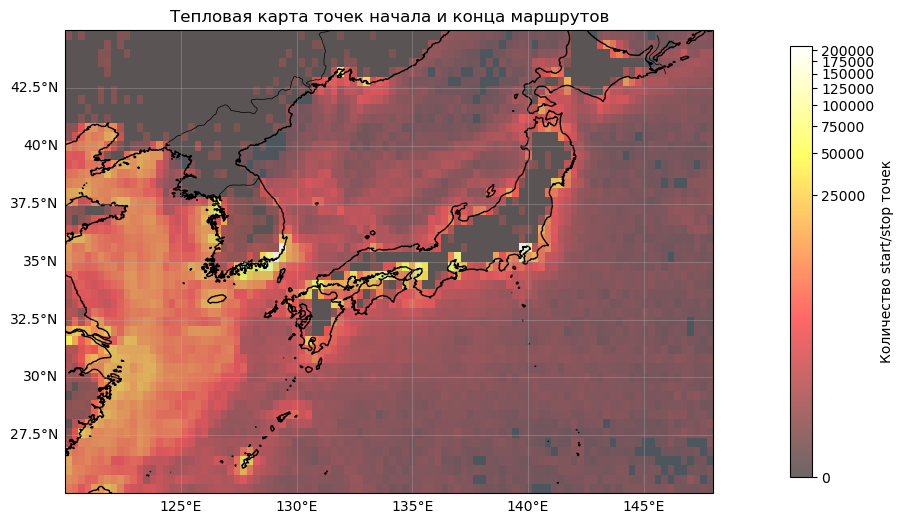

In [11]:
def plot_heatmap_cartopy(ax, heat, x_edges, y_edges, extent, title, gamma=0.2, alpha=0.6):
    min_lon, max_lon, min_lat, max_lat = map(float, extent)

    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # твои базовые настройки
    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # gridlines (похожий стиль как у тебя)
    gl = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # pcolormesh ожидает сетку ребер
    # heat: (ny, nx), y_edges: (ny+1), x_edges: (nx+1)
    # нормализация "под хвосты"
    vmin = float(heat.min())
    vmax = float(heat.max())
    if vmax <= 0:
        vmax = 1.0

    norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)

    mesh = ax.pcolormesh(
        x_edges, y_edges, heat,
        shading="auto",
        cmap='hot',
        alpha=alpha,
        norm=norm,
        transform=ccrs.PlateCarree(),
    )

    ax.set_title(title, fontsize=12)
    return mesh


fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = plot_heatmap_cartopy(
    ax=ax,
    heat=heat_both,
    x_edges=x_edges,
    y_edges=y_edges,
    extent=extent,
    title="Тепловая карта точек начала и конца маршрутов",
    gamma=0.2,
    alpha=0.6,
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/stop точек", rotation=90)

plt.show()


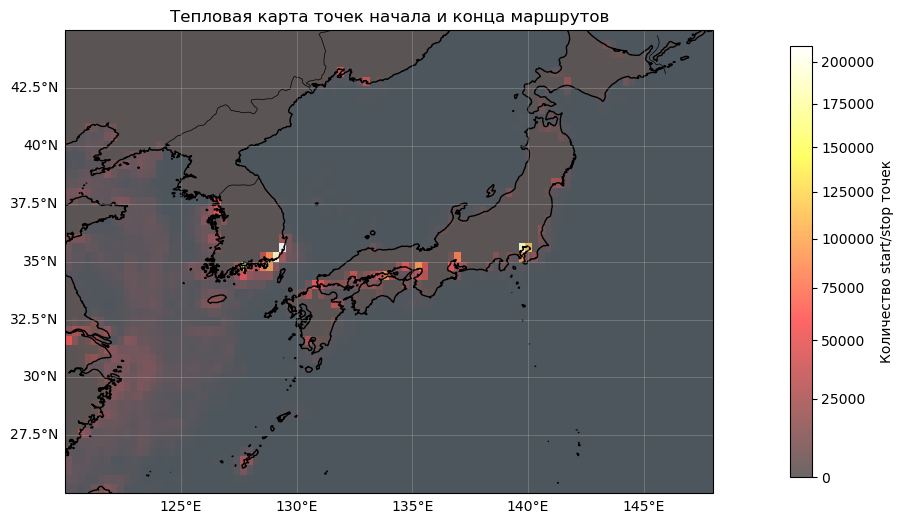

In [12]:
fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = plot_heatmap_cartopy(
    ax=ax,
    heat=heat_both,
    x_edges=x_edges,
    y_edges=y_edges,
    extent=extent,
    title="Тепловая карта точек начала и конца маршрутов",
    gamma=0.8,
    alpha=0.6,
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/stop точек", rotation=90)

plt.show()


Scan tracks: 100%|██████████| 6/6 [00:02<00:00,  2.60chunk/s]

extent: (135.0, 141.0, 33.0, 37.0)
heat_start sum: 507681 heat_end sum: 507220 heat_both sum: 1014901


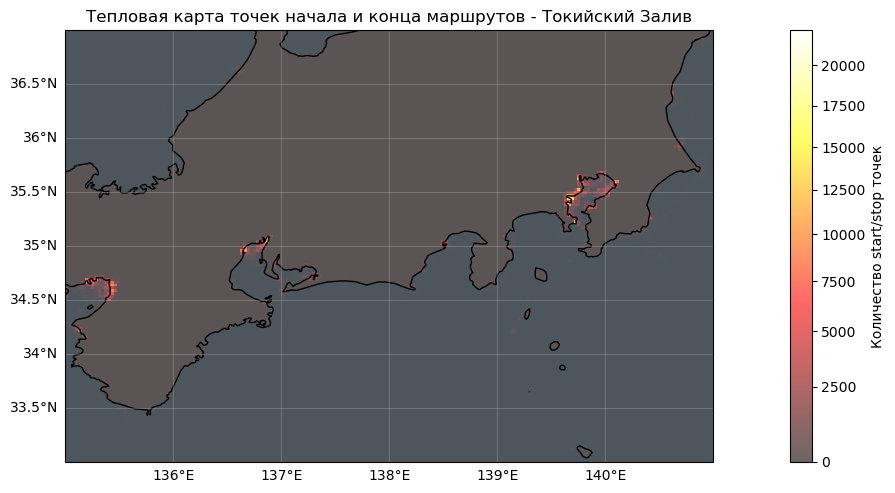

In [13]:
tracks = ds["tracks"]

extent = (135.0, 141.0, 33.0, 37.0)

bins = (200, 150)          # (nx, ny)
chunk_rows = 2_000_000
quality_max_gap_sec = None # например 40*60 если хочешь быстрый суррогат-фильтр по длительности
min_points = None          # например 10/50

heat_start, heat_end, heat_both, x_edges, y_edges = build_start_end_heatmaps_from_tracks(
    tracks,
    extent=extent,
    bins=bins,
    chunk_rows=chunk_rows,
    quality_max_gap_sec=quality_max_gap_sec,
    min_points=min_points,
)

print("extent:", extent)
print("heat_start sum:", int(heat_start.sum()), "heat_end sum:", int(heat_end.sum()), "heat_both sum:", int(heat_both.sum()))

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = plot_heatmap_cartopy(
    ax=ax,
    heat=heat_both,
    x_edges=x_edges,
    y_edges=y_edges,
    extent=extent,
    title="Тепловая карта точек начала и конца маршрутов - Токийский Залив",
    gamma=0.8,
    alpha=0.6,
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/stop точек", rotation=90)

plt.show()


Scan tracks: 100%|██████████| 6/6 [00:02<00:00,  2.52chunk/s]


extent: (139.5, 140.5, 35.0, 35.8)
heat_start sum: 213179 heat_end sum: 213051 heat_both sum: 426230


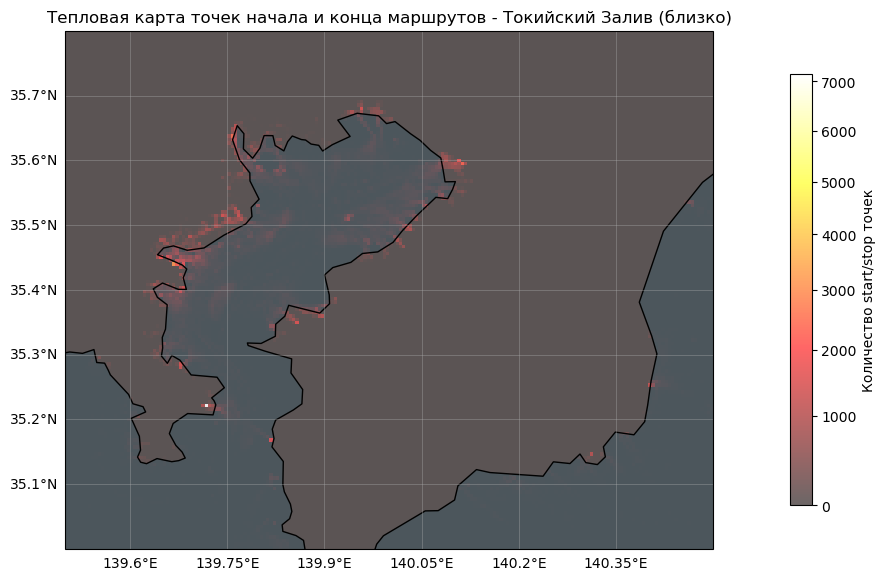

In [14]:
tracks = ds["tracks"]

extent = (139.5, 140.5, 35.0, 35.8)

bins = (200, 150)          # (nx, ny)
chunk_rows = 2_000_000
quality_max_gap_sec = None # например 40*60 если хочешь быстрый суррогат-фильтр по длительности
min_points = None          # например 10/50

heat_start, heat_end, heat_both, x_edges, y_edges = build_start_end_heatmaps_from_tracks(
    tracks,
    extent=extent,
    bins=bins,
    chunk_rows=chunk_rows,
    quality_max_gap_sec=quality_max_gap_sec,
    min_points=min_points,
)

print("extent:", extent)
print("heat_start sum:", int(heat_start.sum()), "heat_end sum:", int(heat_end.sum()), "heat_both sum:", int(heat_both.sum()))

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = plot_heatmap_cartopy(
    ax=ax,
    heat=heat_both,
    x_edges=x_edges,
    y_edges=y_edges,
    extent=extent,
    title="Тепловая карта точек начала и конца маршрутов - Токийский Залив (близко)",
    gamma=0.8,
    alpha=0.6,
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.09, shrink=0.8)
cbar.set_label("Количество start/stop точек", rotation=90)

plt.show()


Scan tracks: 100%|██████████| 6/6 [00:02<00:00,  2.19chunk/s]

extent: (131.5, 133.5, 42.5, 43.5)
heat_start sum: 50606 heat_end sum: 50578 heat_both sum: 101184


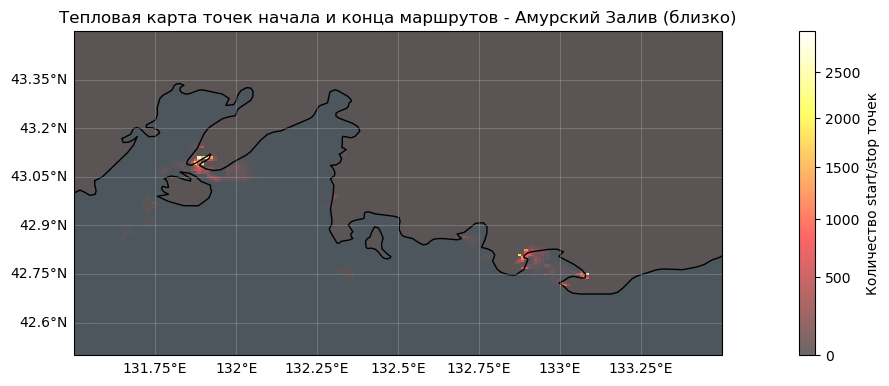

In [15]:
tracks = ds["tracks"]

extent = (131.5, 133.5, 42.5, 43.5)

bins = (200, 150)          # (nx, ny)
chunk_rows = 2_000_000
quality_max_gap_sec = None # например 40*60 если хочешь быстрый суррогат-фильтр по длительности
min_points = None          # например 10/50

heat_start, heat_end, heat_both, x_edges, y_edges = build_start_end_heatmaps_from_tracks(
    tracks,
    extent=extent,
    bins=bins,
    chunk_rows=chunk_rows,
    quality_max_gap_sec=quality_max_gap_sec,
    min_points=min_points,
)

print("extent:", extent)
print("heat_start sum:", int(heat_start.sum()), "heat_end sum:", int(heat_end.sum()), "heat_both sum:", int(heat_both.sum()))

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = plot_heatmap_cartopy(
    ax=ax,
    heat=heat_both,
    x_edges=x_edges,
    y_edges=y_edges,
    extent=extent,
    title="Тепловая карта точек начала и конца маршрутов - Амурский Залив (близко)",
    gamma=0.8,
    alpha=0.6,
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.09, shrink=0.6)
cbar.set_label("Количество start/stop точек", rotation=90)

plt.show()


In [16]:
def meters_per_deg_lat(lat_deg: float) -> float:
    # достаточно точная аппроксимация
    return 111_320.0

def meters_per_deg_lon(lat_deg: float) -> float:
    return 111_320.0 * np.cos(np.deg2rad(lat_deg))

def select_tracks_starting_near_point(
    ds_tracks,
    center_lat: float,
    center_lon: float,
    radius_m: float,
    extent=None,                 # (min_lon, max_lon, min_lat, max_lat) или None
    chunk_rows: int = 2_000_000,
    min_points: int | None = None,
    max_duration_sec: int | None = None,  # суррогат качества по tracks: end-start
):
    """
    Возвращает np.ndarray track_id (int64), которые стартуют в радиусе от (center_lat, center_lon).
    Фильтрация идет по tracks (start_lat/lon).
    """
    n = ds_tracks.shape[0]

    # для быстрой проверки радиуса в "метрах" через deg
    mx = meters_per_deg_lon(center_lat)
    my = meters_per_deg_lat(center_lat)

    min_lon = max_lon = min_lat = max_lat = None
    if extent is not None:
        min_lon, max_lon, min_lat, max_lat = map(float, extent)

    out = []

    for start in tqdm(range(0, n, chunk_rows), desc="Scan tracks (start near A)", unit="chunk"):
        end = min(n, start + chunk_rows)
        block = ds_tracks[start:end]

        m = np.ones(block.shape[0], dtype=bool)

        if min_points is not None:
            m &= (block["points_count"] >= int(min_points))

        if max_duration_sec is not None:
            dur = (block["end_timestamp"].astype(np.int64) - block["start_timestamp"].astype(np.int64))
            m &= (dur <= int(max_duration_sec))

        # extent prefilter
        if extent is not None:
            slat = block["start_lat"].astype(np.float64, copy=False)
            slon = block["start_lon"].astype(np.float64, copy=False)
            m &= np.isfinite(slat) & np.isfinite(slon)
            m &= (slon >= min_lon) & (slon <= max_lon) & (slat >= min_lat) & (slat <= max_lat)

        if not np.any(m):
            continue

        b = block[m]
        slat = b["start_lat"].astype(np.float64, copy=False)
        slon = b["start_lon"].astype(np.float64, copy=False)

        dx = (slon - center_lon) * mx
        dy = (slat - center_lat) * my
        r2 = dx*dx + dy*dy

        mm = (r2 <= radius_m * radius_m)
        if np.any(mm):
            out.append(b["track_id"][mm].astype(np.int64, copy=False))

    if not out:
        return np.empty(0, dtype=np.int64)

    track_ids = np.unique(np.concatenate(out))
    return track_ids


# -----------------------------
# Параметры (примерЕГ: подставь свои)
# -----------------------------
tracks = ds["tracks"]

extent = (120.0, 148.0, 25.0, 45.0)    # как ты сказал, дальше задаешь руками
A_lat, A_lon = 43.10, 131.90           # пример: Владивосток-район
radius_m = 30_000                      # 30 км

min_points = 50                        # optional
max_duration_sec = None                # optional суррогат качества, например 12*3600

track_ids_A = select_tracks_starting_near_point(
    tracks,
    center_lat=A_lat,
    center_lon=A_lon,
    radius_m=radius_m,
    extent=extent,
    chunk_rows=2_000_000,
    min_points=min_points,
    max_duration_sec=max_duration_sec,
)

print("Selected track_ids:", track_ids_A.size)

Scan tracks (start near A): 100%|██████████| 6/6 [00:02<00:00,  2.75chunk/s]

Selected track_ids: 3952


In [17]:
def _utc_date_from_ts(ts: int) -> datetime:
    return datetime.fromtimestamp(int(ts), tz=timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

def iter_position_day_paths(ds, start_ts: int, end_ts: int):
    d0 = _utc_date_from_ts(start_ts)
    d1 = _utc_date_from_ts(end_ts)
    cur = d0
    while cur <= d1:
        y = f"{cur.year:04d}"
        m = f"{cur.month:02d}"
        d = f"{cur.day:02d}"
        path = f"/positions/{y}/{m}/{d}"
        if path in ds:
            yield path
        cur += timedelta(days=1)


def fetch_tracks_time_range(ds_tracks, track_ids: np.ndarray, chunk_rows: int = 2_000_000):
    """
    Находит min start_timestamp и max end_timestamp для выбранных треков.
    Делает скан по tracks чанками, используя set для membership.
    """
    if track_ids.size == 0:
        return None

    wanted = set(map(int, track_ids.tolist()))
    n = ds_tracks.shape[0]

    min_ts = None
    max_ts = None

    for start in tqdm(range(0, n, chunk_rows), desc="Scan tracks for time range", unit="chunk"):
        end = min(n, start + chunk_rows)
        block = ds_tracks[start:end]
        # membership по track_id (vectorized через np.isin может быть тяжелее на огромных чанках,
        # но здесь track_ids обычно относительно мало; сделаем np.isin)
        m = np.isin(block["track_id"], track_ids, assume_unique=False)
        if not np.any(m):
            continue
        b = block[m]
        smin = int(b["start_timestamp"].min())
        emax = int(b["end_timestamp"].max())
        min_ts = smin if min_ts is None else min(min_ts, smin)
        max_ts = emax if max_ts is None else max(max_ts, emax)

    if min_ts is None:
        return None
    return min_ts, max_ts


def load_points_for_track_ids(
    ds,
    track_ids: np.ndarray,
    start_ts: int,
    end_ts: int,
    chunk_rows: int = 2_000_000,
):
    """
    Проходит по positions в диапазоне дней [start_ts, end_ts] и вытаскивает точки,
    где track_id ∈ track_ids.

    Возвращает массивы ts, lat, lon, track_id (каждая точка хранит свой track_id).
    """
    if track_ids.size == 0:
        return None

    track_ids = track_ids.astype(np.int64, copy=False)

    ts_all = []
    lat_all = []
    lon_all = []
    tid_all = []

    day_paths = list(iter_position_day_paths(ds, start_ts, end_ts))
    if not day_paths:
        return None

    for path in tqdm(day_paths, desc="Days (positions scan)", unit="day"):
        dset = ds[path]
        n = dset.shape[0]

        for s in tqdm(range(0, n, chunk_rows), desc=f"Chunks {path[-10:]}", leave=False, unit="chunk"):
            e = min(s + chunk_rows, n)
            block = dset[s:e]

            m = np.isin(block["track_id"], track_ids, assume_unique=False)
            if not np.any(m):
                continue

            part = block[m]
            ts_all.append(part["timestamp"].astype(np.int64, copy=False))
            lat_all.append(part["lat"].astype(np.float64, copy=False))
            lon_all.append(part["lon"].astype(np.float64, copy=False))
            tid_all.append(part["track_id"].astype(np.int64, copy=False))

    if not ts_all:
        return None

    ts = np.concatenate(ts_all)
    lat = np.concatenate(lat_all)
    lon = np.concatenate(lon_all)
    tid = np.concatenate(tid_all)

    # сортировка по (track_id, timestamp), чтобы удобно рисовать сегментами
    order = np.lexsort((ts, tid))  # primary tid, secondary ts
    return ts[order], lat[order], lon[order], tid[order]


# ---- диапазон дней по выбранным track_ids
time_range = fetch_tracks_time_range(tracks, track_ids_A, chunk_rows=2_000_000)
print("time_range:", time_range)

if time_range is None:
    print("No matching tracks found in tracks table (unexpected).")
else:
    min_ts, max_ts = time_range
    pts = load_points_for_track_ids(
        ds,
        track_ids=track_ids_A,
        start_ts=min_ts,
        end_ts=max_ts,
        chunk_rows=2_000_000,
    )
    if pts is None:
        print("No points found for selected track_ids in scanned positions.")
    else:
        ts_pts, lat_pts, lon_pts, tid_pts = pts
        print("Loaded points:", ts_pts.size, "unique tracks in points:", np.unique(tid_pts).size)

Scan tracks for time range: 100%|██████████| 6/6 [00:02<00:00,  2.25chunk/s]


time_range: (1730200664, 1752132326)


Days (positions scan): 100%|██████████| 247/247 [03:48<00:00,  1.08day/s]

Loaded points: 624655 unique tracks in points: 3952


Plot tracks: 100%|██████████| 3952/3952 [00:00<00:00, 4333.43track/s]


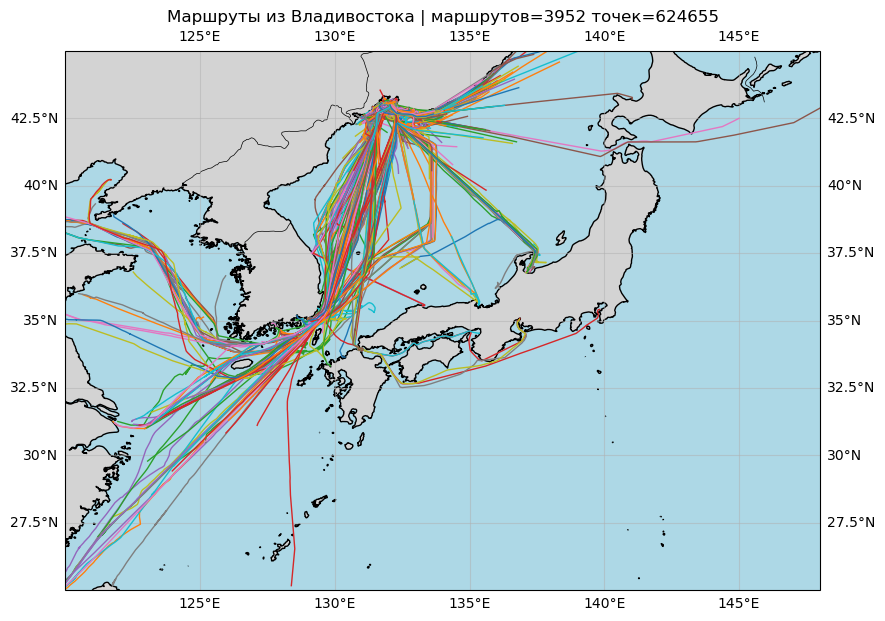

In [18]:
max_tracks_to_plot=200_000

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lon, max_lon, min_lat, max_lat = map(float, extent)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# стиль
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# границы групп track_id
uniq, idx_start = np.unique(tid_pts, return_index=True)
# idx_start - позиции первого вхождения каждого track_id в отсортированном tid_pts
order = np.argsort(idx_start)
uniq = uniq[order]
idx_start = idx_start[order]
idx_end = np.r_[idx_start[1:], tid_pts.size]

if max_tracks_to_plot is not None and uniq.size > max_tracks_to_plot:
    uniq = uniq[:max_tracks_to_plot]
    idx_start = idx_start[:max_tracks_to_plot]
    idx_end = idx_end[:max_tracks_to_plot]

# цвета - пусть matplotlib сам выбирает из tab20 циклом
for s, e in tqdm(list(zip(idx_start, idx_end)), desc="Plot tracks", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_pts[s:e], lat_pts[s:e], linewidth=1.0, transform=ccrs.PlateCarree())

ax.set_title(f"Маршруты из Владивостока | маршрутов={uniq.size} точек={len(lat_pts)}", fontsize=12)
plt.show()


In [19]:
# очистка памяти
# del ts_pts, lat_pts, lon_pts, tid_pts, pts
# gc.collect()

In [20]:
tracks = ds["tracks"]

extent = (110.0, 151.0, 18.0, 45.5)
A_lat, A_lon = 35.56, 139.90
radius_m = 30_000

min_points = 50
max_duration_sec = None

track_ids_A = select_tracks_starting_near_point(
    tracks,
    center_lat=A_lat,
    center_lon=A_lon,
    radius_m=radius_m,
    extent=extent,
    chunk_rows=2_000_000,
    min_points=min_points,
    max_duration_sec=max_duration_sec,
)

print("Selected track_ids:", track_ids_A.size)

#---------

time_range = fetch_tracks_time_range(tracks, track_ids_A, chunk_rows=2_000_000)
print("time_range:", time_range)

if time_range is None:
    print("No matching tracks found in tracks table (unexpected).")
else:
    min_ts, max_ts = time_range
    pts = load_points_for_track_ids(
        ds,
        track_ids=track_ids_A,
        start_ts=min_ts,
        end_ts=max_ts,
        chunk_rows=2_000_000,
    )
    if pts is None:
        print("No points found for selected track_ids in scanned positions.")
    else:
        ts_pts, lat_pts, lon_pts, tid_pts = pts
        print("Loaded points:", ts_pts.size, "unique tracks in points:", np.unique(tid_pts).size)


Scan tracks (start near A): 100%|██████████| 6/6 [00:02<00:00,  2.49chunk/s]


Selected track_ids: 30416


Scan tracks for time range: 100%|██████████| 6/6 [00:02<00:00,  2.24chunk/s]


time_range: (1730200230, 1752132205)


Days (positions scan): 100%|██████████| 247/247 [03:49<00:00,  1.08day/s]


Loaded points: 5070225 unique tracks in points: 30416


Plot tracks: 100%|██████████| 30416/30416 [00:07<00:00, 3993.47track/s]


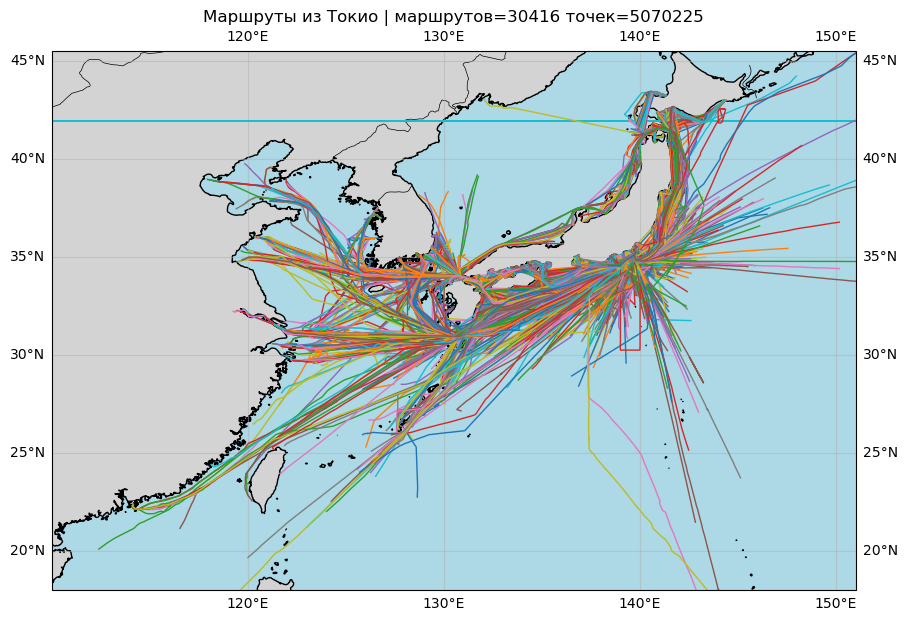

In [21]:
max_tracks_to_plot=200_000

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lon, max_lon, min_lat, max_lat = map(float, extent)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# стиль
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# границы групп track_id
uniq, idx_start = np.unique(tid_pts, return_index=True)
# idx_start - позиции первого вхождения каждого track_id в отсортированном tid_pts
order = np.argsort(idx_start)
uniq = uniq[order]
idx_start = idx_start[order]
idx_end = np.r_[idx_start[1:], tid_pts.size]

if max_tracks_to_plot is not None and uniq.size > max_tracks_to_plot:
    uniq = uniq[:max_tracks_to_plot]
    idx_start = idx_start[:max_tracks_to_plot]
    idx_end = idx_end[:max_tracks_to_plot]

# цвета - пусть matplotlib сам выбирает из tab20 циклом
for s, e in tqdm(list(zip(idx_start, idx_end)), desc="Plot tracks", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_pts[s:e], lat_pts[s:e], linewidth=1.0, transform=ccrs.PlateCarree())

ax.set_title(f"Маршруты из Токио | маршрутов={uniq.size} точек={len(lat_pts)}", fontsize=12)
plt.show()

In [ ]:
def meters_per_deg_lat(lat_deg: float) -> float:
    return 111_320.0

def meters_per_deg_lon(lat_deg: float) -> float:
    return 111_320.0 * np.cos(np.deg2rad(lat_deg))

def select_tracks_A_to_B(
    ds_tracks,
    A_lat: float, A_lon: float, A_radius_m: float,
    B_lat: float, B_lon: float, B_radius_m: float,
    extent=None,                    # (min_lon, max_lon, min_lat, max_lat) или None
    chunk_rows: int = 2_000_000,
    min_points: int | None = None,
    max_duration_sec: int | None = None,  # быстрый суррогат-фильтр по tracks: (end-start)
):
    """
    Возвращает:
      - track_ids (np.int64[])
      - min_ts, max_ts (по выбранным трекам) чтобы ограничить чтение positions по дням
    """
    n = ds_tracks.shape[0]

    # метры на градус (для быстрых dx/dy)
    mxA = meters_per_deg_lon(A_lat); myA = meters_per_deg_lat(A_lat)
    mxB = meters_per_deg_lon(B_lat); myB = meters_per_deg_lat(B_lat)

    A_r2 = float(A_radius_m) * float(A_radius_m)
    B_r2 = float(B_radius_m) * float(B_radius_m)

    if extent is not None:
        min_lon, max_lon, min_lat, max_lat = map(float, extent)
    else:
        min_lon = max_lon = min_lat = max_lat = None

    out = []
    min_ts = None
    max_ts = None

    for start in tqdm(range(0, n, chunk_rows), desc="Scan tracks (A->B)", unit="chunk"):
        end = min(n, start + chunk_rows)
        block = ds_tracks[start:end]

        m = np.ones(block.shape[0], dtype=bool)

        if min_points is not None:
            m &= (block["points_count"] >= int(min_points))

        if max_duration_sec is not None:
            dur = (block["end_timestamp"].astype(np.int64) - block["start_timestamp"].astype(np.int64))
            m &= (dur <= int(max_duration_sec))

        # грубый extent prefilter по start/end (ускоряет, если region небольшой)
        if extent is not None:
            slat = block["start_lat"].astype(np.float64, copy=False)
            slon = block["start_lon"].astype(np.float64, copy=False)
            elat = block["end_lat"].astype(np.float64, copy=False)
            elon = block["end_lon"].astype(np.float64, copy=False)

            m &= (
                np.isfinite(slat) & np.isfinite(slon) & np.isfinite(elat) & np.isfinite(elon)
                & (slon >= min_lon) & (slon <= max_lon) & (slat >= min_lat) & (slat <= max_lat)
                & (elon >= min_lon) & (elon <= max_lon) & (elat >= min_lat) & (elat <= max_lat)
            )

        if not np.any(m):
            continue

        b = block[m]

        # start in A
        slat = b["start_lat"].astype(np.float64, copy=False)
        slon = b["start_lon"].astype(np.float64, copy=False)
        dxA = (slon - A_lon) * mxA
        dyA = (slat - A_lat) * myA
        mA = (dxA*dxA + dyA*dyA) <= A_r2

        if not np.any(mA):
            continue

        b = b[mA]

        # end in B
        elat = b["end_lat"].astype(np.float64, copy=False)
        elon = b["end_lon"].astype(np.float64, copy=False)
        dxB = (elon - B_lon) * mxB
        dyB = (elat - B_lat) * myB
        mB = (dxB*dxB + dyB*dyB) <= B_r2

        if not np.any(mB):
            continue

        b = b[mB]

        out.append(b["track_id"].astype(np.int64, copy=False))

        smin = int(b["start_timestamp"].min())
        emax = int(b["end_timestamp"].max())
        min_ts = smin if min_ts is None else min(min_ts, smin)
        max_ts = emax if max_ts is None else max(max_ts, emax)

    if not out:
        return np.empty(0, dtype=np.int64), None, None

    track_ids = np.unique(np.concatenate(out))
    return track_ids, min_ts, max_ts


# -----------------------------
# Параметры (пример)
# -----------------------------
tracks = ds["tracks"]

extent = (120.0, 148.0, 25.0, 45.0)

# Точка A
A_lat, A_lon = 43.10, 131.90
A_radius_m = 30_000

# Точка B
B_lat, B_lon = 36.78, 137.20
B_radius_m = 30_000

min_points = 50
max_duration_sec = None   # например 12*3600 если хочешь быстрый фильтр

track_ids_AB, min_ts_AB, max_ts_AB = select_tracks_A_to_B(
    tracks,
    A_lat, A_lon, A_radius_m,
    B_lat, B_lon, B_radius_m,
    extent=extent,
    chunk_rows=2_000_000,
    min_points=min_points,
    max_duration_sec=max_duration_sec,
)

print("Selected A->B track_ids:", track_ids_AB.size)
print("Time range:", (min_ts_AB, max_ts_AB))

Scan tracks (A→B): 100%|██████████| 6/6 [00:02<00:00,  2.44chunk/s]

Selected A→B track_ids: 15
Time range: (1741648535, 1752005433)


In [ ]:
def _utc_date_from_ts(ts: int) -> datetime:
    return datetime.fromtimestamp(int(ts), tz=timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

def iter_position_day_paths(ds, start_ts: int, end_ts: int):
    d0 = _utc_date_from_ts(start_ts)
    d1 = _utc_date_from_ts(end_ts)
    cur = d0
    while cur <= d1:
        y = f"{cur.year:04d}"
        m = f"{cur.month:02d}"
        d = f"{cur.day:02d}"
        path = f"/positions/{y}/{m}/{d}"
        if path in ds:
            yield path
        cur += timedelta(days=1)

def load_points_for_track_ids(ds, track_ids: np.ndarray, start_ts: int, end_ts: int, chunk_rows: int = 2_000_000):
    if track_ids.size == 0:
        return None

    track_ids = track_ids.astype(np.int64, copy=False)

    ts_all, lat_all, lon_all, tid_all = [], [], [], []
    day_paths = list(iter_position_day_paths(ds, start_ts, end_ts))
    if not day_paths:
        return None

    for path in tqdm(day_paths, desc="Days (positions scan)", unit="day"):
        dset = ds[path]
        n = dset.shape[0]

        for s in tqdm(range(0, n, chunk_rows), desc=f"Chunks {path[-10:]}", leave=False, unit="chunk"):
            e = min(s + chunk_rows, n)
            block = dset[s:e]

            m = np.isin(block["track_id"], track_ids, assume_unique=False)
            if not np.any(m):
                continue

            part = block[m]
            ts_all.append(part["timestamp"].astype(np.int64, copy=False))
            lat_all.append(part["lat"].astype(np.float64, copy=False))
            lon_all.append(part["lon"].astype(np.float64, copy=False))
            tid_all.append(part["track_id"].astype(np.int64, copy=False))

    if not ts_all:
        return None

    ts = np.concatenate(ts_all)
    lat = np.concatenate(lat_all)
    lon = np.concatenate(lon_all)
    tid = np.concatenate(tid_all)

    # сортировка по (track_id, timestamp)
    order = np.lexsort((ts, tid))
    return ts[order], lat[order], lon[order], tid[order]


if track_ids_AB.size == 0 or min_ts_AB is None:
    print("No A->B tracks found for given A/B/radius/filters.")
else:
    pts_AB = load_points_for_track_ids(
        ds,
        track_ids=track_ids_AB,
        start_ts=int(min_ts_AB),
        end_ts=int(max_ts_AB),
        chunk_rows=2_000_000,
    )

    if pts_AB is None:
        print("No points found for selected A->B track_ids in scanned positions.")
    else:
        ts_AB, lat_AB, lon_AB, tid_AB = pts_AB
        print("Loaded points:", ts_AB.size, "| unique tracks in points:", np.unique(tid_AB).size)

Days (positions scan): 100%|██████████| 116/116 [01:50<00:00,  1.05day/s]

Loaded points: 4194 | unique tracks in points: 15


Plot tracks: 100%|██████████| 15/15 [00:00<00:00, 3073.95track/s]


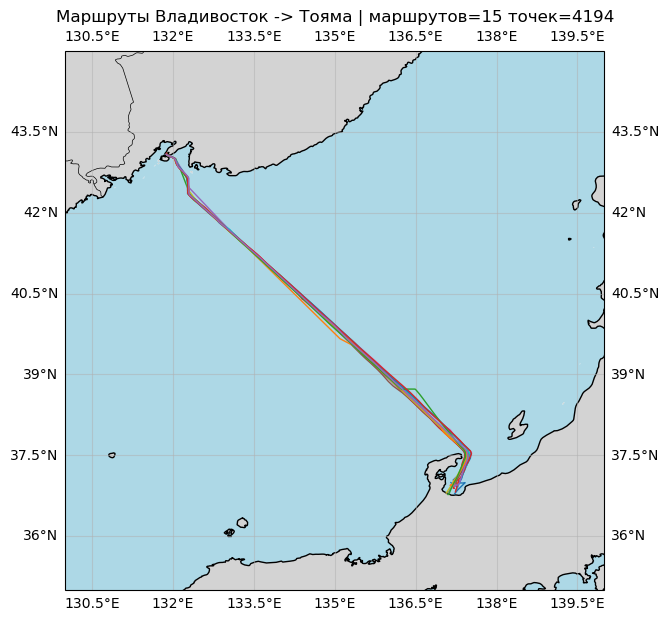

In [24]:
extent = (130.0, 140.0, 35.0, 45.0)

max_tracks_to_plot=200_000

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lon, max_lon, min_lat, max_lat = map(float, extent)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

uniq, idx_start = np.unique(tid_AB, return_index=True)
order = np.argsort(idx_start)
uniq = uniq[order]
idx_start = idx_start[order]
idx_end = np.r_[idx_start[1:], tid_AB.size]

if max_tracks_to_plot is not None and uniq.size > max_tracks_to_plot:
    uniq = uniq[:max_tracks_to_plot]
    idx_start = idx_start[:max_tracks_to_plot]
    idx_end = idx_end[:max_tracks_to_plot]

for s, e in tqdm(list(zip(idx_start, idx_end)), desc="Plot tracks", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_AB[s:e], lat_AB[s:e], linewidth=1.0, transform=ccrs.PlateCarree())

ax.set_title(f"Маршруты Владивосток -> Тояма | маршрутов={uniq.size} точек={len(lat_AB)}", fontsize=12)
plt.show()

In [25]:
def meters_per_deg_lat(lat_deg: float) -> float:
    return 111_320.0

def meters_per_deg_lon(lat_deg: float) -> float:
    return 111_320.0 * np.cos(np.deg2rad(lat_deg))

def select_tracks_AB_and_BA_one_pass(
    ds_tracks,
    A_lat: float, A_lon: float, A_radius_m: float,
    B_lat: float, B_lon: float, B_radius_m: float,
    extent=None,                    # (min_lon, max_lon, min_lat, max_lat) или None
    chunk_rows: int = 2_000_000,
    min_points: int | None = None,
    max_duration_sec: int | None = None,  # суррогат-фильтр по длительности (end-start)
):
    """
    Возвращает:
      AB_ids: start∈A & end∈B
      BA_ids: start∈B & end∈A
      min_ts, max_ts: диапазон времени по объединению AB+BA (для ограничения чтения positions)
    """
    n = ds_tracks.shape[0]

    mxA = meters_per_deg_lon(A_lat); myA = meters_per_deg_lat(A_lat)
    mxB = meters_per_deg_lon(B_lat); myB = meters_per_deg_lat(B_lat)

    A_r2 = float(A_radius_m) * float(A_radius_m)
    B_r2 = float(B_radius_m) * float(B_radius_m)

    if extent is not None:
        min_lon, max_lon, min_lat, max_lat = map(float, extent)
    else:
        min_lon = max_lon = min_lat = max_lat = None

    AB_out = []
    BA_out = []
    min_ts = None
    max_ts = None

    for start in tqdm(range(0, n, chunk_rows), desc="Scan tracks (AB & BA)", unit="chunk"):
        end = min(n, start + chunk_rows)
        block = ds_tracks[start:end]

        m = np.ones(block.shape[0], dtype=bool)

        if min_points is not None:
            m &= (block["points_count"] >= int(min_points))

        if max_duration_sec is not None:
            dur = (block["end_timestamp"].astype(np.int64) - block["start_timestamp"].astype(np.int64))
            m &= (dur <= int(max_duration_sec))

        # prefilter by extent for start+end
        slat = block["start_lat"].astype(np.float64, copy=False)
        slon = block["start_lon"].astype(np.float64, copy=False)
        elat = block["end_lat"].astype(np.float64, copy=False)
        elon = block["end_lon"].astype(np.float64, copy=False)

        m &= np.isfinite(slat) & np.isfinite(slon) & np.isfinite(elat) & np.isfinite(elon)

        if extent is not None:
            m &= (
                (slon >= min_lon) & (slon <= max_lon) & (slat >= min_lat) & (slat <= max_lat) &
                (elon >= min_lon) & (elon <= max_lon) & (elat >= min_lat) & (elat <= max_lat)
            )

        if not np.any(m):
            continue

        b = block[m]
        slat = slat[m]; slon = slon[m]; elat = elat[m]; elon = elon[m]

        # start near A / B
        dx_sA = (slon - A_lon) * mxA
        dy_sA = (slat - A_lat) * myA
        startA = (dx_sA*dx_sA + dy_sA*dy_sA) <= A_r2

        dx_sB = (slon - B_lon) * mxB
        dy_sB = (slat - B_lat) * myB
        startB = (dx_sB*dx_sB + dy_sB*dy_sB) <= B_r2

        # end near A / B
        dx_eA = (elon - A_lon) * mxA
        dy_eA = (elat - A_lat) * myA
        endA = (dx_eA*dx_eA + dy_eA*dy_eA) <= A_r2

        dx_eB = (elon - B_lon) * mxB
        dy_eB = (elat - B_lat) * myB
        endB = (dx_eB*dx_eB + dy_eB*dy_eB) <= B_r2

        mAB = startA & endB
        mBA = startB & endA

        if np.any(mAB):
            bb = b[mAB]
            AB_out.append(bb["track_id"].astype(np.int64, copy=False))
            smin = int(bb["start_timestamp"].min())
            emax = int(bb["end_timestamp"].max())
            min_ts = smin if min_ts is None else min(min_ts, smin)
            max_ts = emax if max_ts is None else max(max_ts, emax)

        if np.any(mBA):
            bb = b[mBA]
            BA_out.append(bb["track_id"].astype(np.int64, copy=False))
            smin = int(bb["start_timestamp"].min())
            emax = int(bb["end_timestamp"].max())
            min_ts = smin if min_ts is None else min(min_ts, smin)
            max_ts = emax if max_ts is None else max(max_ts, emax)

    AB_ids = np.unique(np.concatenate(AB_out)) if AB_out else np.empty(0, dtype=np.int64)
    BA_ids = np.unique(np.concatenate(BA_out)) if BA_out else np.empty(0, dtype=np.int64)
    return AB_ids, BA_ids, min_ts, max_ts


# -----------------------------
# Параметры (пример: ты подставишь свои)
# -----------------------------
tracks = ds["tracks"]

extent = (130.0, 140.0, 35.0, 45.0)

A_lat, A_lon = 43.10, 131.90
A_radius_m = 35_000

B_lat, B_lon = 36.78, 137.20
B_radius_m = 35_000

min_points = 50
max_duration_sec = None

AB_ids, BA_ids, min_ts, max_ts = select_tracks_AB_and_BA_one_pass(
    tracks,
    A_lat, A_lon, A_radius_m,
    B_lat, B_lon, B_radius_m,
    extent=extent,
    chunk_rows=2_000_000,
    min_points=min_points,
    max_duration_sec=max_duration_sec,
)

print("AB_ids:", AB_ids.size, "BA_ids:", BA_ids.size, "time_range:", (min_ts, max_ts))

Scan tracks (AB & BA): 100%|██████████| 6/6 [00:02<00:00,  2.52chunk/s]

AB_ids: 15 BA_ids: 17 time_range: (1740724246, 1752091532)


In [26]:
def _utc_date_from_ts(ts: int) -> datetime:
    return datetime.fromtimestamp(int(ts), tz=timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

def iter_position_day_paths(ds, start_ts: int, end_ts: int):
    d0 = _utc_date_from_ts(start_ts)
    d1 = _utc_date_from_ts(end_ts)
    cur = d0
    while cur <= d1:
        y = f"{cur.year:04d}"
        m = f"{cur.month:02d}"
        d = f"{cur.day:02d}"
        path = f"/positions/{y}/{m}/{d}"
        if path in ds:
            yield path
        cur += timedelta(days=1)

def load_points_for_track_ids(ds, track_ids: np.ndarray, start_ts: int, end_ts: int, chunk_rows: int = 2_000_000):
    if track_ids.size == 0:
        return None

    track_ids = track_ids.astype(np.int64, copy=False)

    ts_all, lat_all, lon_all, tid_all = [], [], [], []
    day_paths = list(iter_position_day_paths(ds, start_ts, end_ts))
    if not day_paths:
        return None

    for path in tqdm(day_paths, desc="Days (positions scan)", unit="day"):
        dset = ds[path]
        n = dset.shape[0]

        for s in tqdm(range(0, n, chunk_rows), desc=f"Chunks {path[-10:]}", leave=False, unit="chunk"):
            e = min(s + chunk_rows, n)
            block = dset[s:e]

            m = np.isin(block["track_id"], track_ids, assume_unique=False)
            if not np.any(m):
                continue

            part = block[m]
            ts_all.append(part["timestamp"].astype(np.int64, copy=False))
            lat_all.append(part["lat"].astype(np.float64, copy=False))
            lon_all.append(part["lon"].astype(np.float64, copy=False))
            tid_all.append(part["track_id"].astype(np.int64, copy=False))

    if not ts_all:
        return None

    ts = np.concatenate(ts_all)
    lat = np.concatenate(lat_all)
    lon = np.concatenate(lon_all)
    tid = np.concatenate(tid_all)

    order = np.lexsort((ts, tid))  # (track_id, timestamp)
    return ts[order], lat[order], lon[order], tid[order]


# ---- грузим точки для объединения
all_ids = np.unique(np.concatenate([AB_ids, BA_ids])) if (AB_ids.size or BA_ids.size) else np.empty(0, dtype=np.int64)

if all_ids.size == 0 or min_ts is None:
    print("No tracks for AB/BA with given settings.")
else:
    pts = load_points_for_track_ids(ds, all_ids, int(min_ts), int(max_ts), chunk_rows=2_000_000)
    if pts is None:
        print("No points found in positions for selected track_ids.")
    else:
        ts_all, lat_all, lon_all, tid_all = pts
        print("Loaded points:", ts_all.size, "| unique tracks in points:", np.unique(tid_all).size)

        # split to AB vs BA by membership
        AB_set = set(map(int, AB_ids.tolist()))
        is_AB = np.fromiter((int(t) in AB_set for t in tid_all), count=tid_all.size, dtype=bool)

        # AB arrays
        ts_AB = ts_all[is_AB]; lat_AB = lat_all[is_AB]; lon_AB = lon_all[is_AB]; tid_AB = tid_all[is_AB]
        # BA arrays
        ts_BA = ts_all[~is_AB]; lat_BA = lat_all[~is_AB]; lon_BA = lon_all[~is_AB]; tid_BA = tid_all[~is_AB]

        print("AB points:", ts_AB.size, "tracks:", np.unique(tid_AB).size)
        print("BA points:", ts_BA.size, "tracks:", np.unique(tid_BA).size)

Days (positions scan): 100%|██████████| 127/127 [02:01<00:00,  1.05day/s]

Loaded points: 8737 | unique tracks in points: 32
AB points: 4194 tracks: 15
BA points: 4543 tracks: 17


Plot BA (blue): 100%|██████████| 17/17 [00:00<00:00, 3620.00track/s]


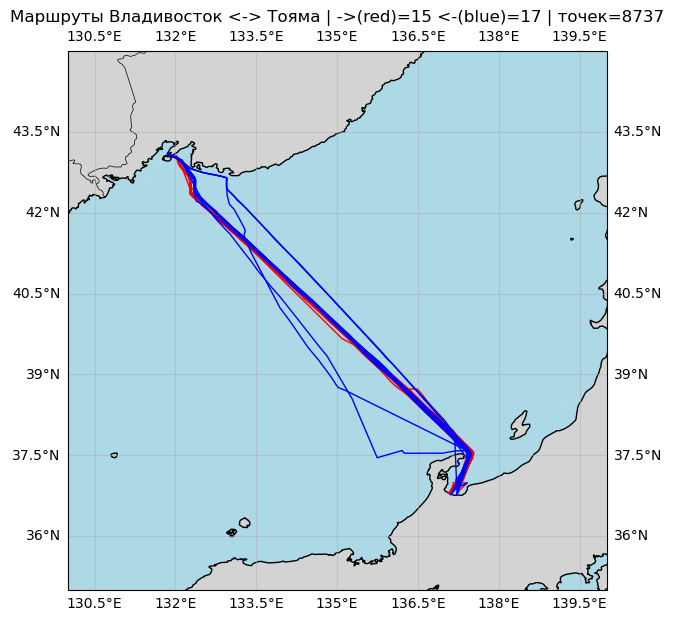

In [27]:
extent = (130.0, 140.0, 35.0, 45.0)  # как ты задаешь руками
max_tracks_to_plot = 200_000

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lon, max_lon, min_lat, max_lat = map(float, extent)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# --- AB (красный)
uniq, idx_start = np.unique(tid_AB, return_index=True)
order = np.argsort(idx_start)
uniq = uniq[order]; idx_start = idx_start[order]
idx_end = np.r_[idx_start[1:], tid_AB.size]

if max_tracks_to_plot is not None and uniq.size > max_tracks_to_plot:
    uniq = uniq[:max_tracks_to_plot]
    idx_start = idx_start[:max_tracks_to_plot]
    idx_end = idx_end[:max_tracks_to_plot]

for s, e in tqdm(list(zip(idx_start, idx_end)), desc="Plot AB (red)", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_AB[s:e], lat_AB[s:e], linewidth=1.0, color="red", transform=ccrs.PlateCarree())

# --- BA (синий)
uniq2, idx_start2 = np.unique(tid_BA, return_index=True)
order2 = np.argsort(idx_start2)
uniq2 = uniq2[order2]; idx_start2 = idx_start2[order2]
idx_end2 = np.r_[idx_start2[1:], tid_BA.size]

if max_tracks_to_plot is not None and uniq2.size > max_tracks_to_plot:
    uniq2 = uniq2[:max_tracks_to_plot]
    idx_start2 = idx_start2[:max_tracks_to_plot]
    idx_end2 = idx_end2[:max_tracks_to_plot]

for s, e in tqdm(list(zip(idx_start2, idx_end2)), desc="Plot BA (blue)", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_BA[s:e], lat_BA[s:e], linewidth=1.0, color="blue", transform=ccrs.PlateCarree())

ax.set_title(
    f"Маршруты Владивосток <-> Тояма | ->(red)={uniq.size} <-(blue)={uniq2.size} | точек={len(lat_AB)+len(lat_BA)}",
    fontsize=12
)
plt.show()

In [28]:
tracks = ds["tracks"]

extent = (128.35, 141.2, 32.8, 36.4)

A_lat, A_lon = 35.516, 139.86
A_radius_m = 35_000

B_lat, B_lon = 35.112, 129.055
B_radius_m = 35_000

min_points = 50
max_duration_sec = None

AB_ids, BA_ids, min_ts, max_ts = select_tracks_AB_and_BA_one_pass(
    tracks,
    A_lat, A_lon, A_radius_m,
    B_lat, B_lon, B_radius_m,
    extent=extent,
    chunk_rows=2_000_000,
    min_points=min_points,
    max_duration_sec=max_duration_sec,
)

print("AB_ids:", AB_ids.size, "BA_ids:", BA_ids.size, "time_range:", (min_ts, max_ts))

# ---- грузим точки для объединения
all_ids = np.unique(np.concatenate([AB_ids, BA_ids])) if (AB_ids.size or BA_ids.size) else np.empty(0, dtype=np.int64)

if all_ids.size == 0 or min_ts is None:
    print("No tracks for AB/BA with given settings.")
else:
    pts = load_points_for_track_ids(ds, all_ids, int(min_ts), int(max_ts), chunk_rows=2_000_000)
    if pts is None:
        print("No points found in positions for selected track_ids.")
    else:
        ts_all, lat_all, lon_all, tid_all = pts
        print("Loaded points:", ts_all.size, "| unique tracks in points:", np.unique(tid_all).size)

        # split to AB vs BA by membership
        AB_set = set(map(int, AB_ids.tolist()))
        is_AB = np.fromiter((int(t) in AB_set for t in tid_all), count=tid_all.size, dtype=bool)

        # AB arrays
        ts_AB = ts_all[is_AB]; lat_AB = lat_all[is_AB]; lon_AB = lon_all[is_AB]; tid_AB = tid_all[is_AB]
        # BA arrays
        ts_BA = ts_all[~is_AB]; lat_BA = lat_all[~is_AB]; lon_BA = lon_all[~is_AB]; tid_BA = tid_all[~is_AB]

        print("AB points:", ts_AB.size, "tracks:", np.unique(tid_AB).size)
        print("BA points:", ts_BA.size, "tracks:", np.unique(tid_BA).size)

Scan tracks (AB & BA): 100%|██████████| 6/6 [00:02<00:00,  2.46chunk/s]


AB_ids: 191 BA_ids: 357 time_range: (1730418613, 1752013268)


Days (positions scan): 100%|██████████| 243/243 [03:53<00:00,  1.04day/s]

Loaded points: 155843 | unique tracks in points: 548
AB points: 59698 tracks: 191
BA points: 96145 tracks: 357


Plot BA (blue): 100%|██████████| 357/357 [00:00<00:00, 4135.62track/s]


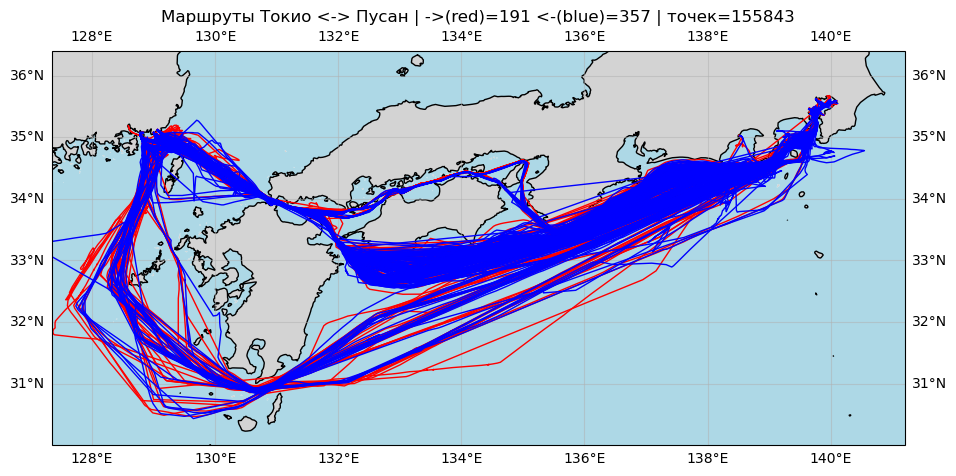

In [29]:
extent = (127.35, 141.2, 30.0, 36.4)
max_tracks_to_plot = 200_000

fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lon, max_lon, min_lat, max_lat = map(float, extent)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.5)

# --- AB (красный)
uniq, idx_start = np.unique(tid_AB, return_index=True)
order = np.argsort(idx_start)
uniq = uniq[order]; idx_start = idx_start[order]
idx_end = np.r_[idx_start[1:], tid_AB.size]

if max_tracks_to_plot is not None and uniq.size > max_tracks_to_plot:
    uniq = uniq[:max_tracks_to_plot]
    idx_start = idx_start[:max_tracks_to_plot]
    idx_end = idx_end[:max_tracks_to_plot]

for s, e in tqdm(list(zip(idx_start, idx_end)), desc="Plot AB (red)", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_AB[s:e], lat_AB[s:e], linewidth=1.0, color="red", transform=ccrs.PlateCarree())

# --- BA (синий)
uniq2, idx_start2 = np.unique(tid_BA, return_index=True)
order2 = np.argsort(idx_start2)
uniq2 = uniq2[order2]; idx_start2 = idx_start2[order2]
idx_end2 = np.r_[idx_start2[1:], tid_BA.size]

if max_tracks_to_plot is not None and uniq2.size > max_tracks_to_plot:
    uniq2 = uniq2[:max_tracks_to_plot]
    idx_start2 = idx_start2[:max_tracks_to_plot]
    idx_end2 = idx_end2[:max_tracks_to_plot]

for s, e in tqdm(list(zip(idx_start2, idx_end2)), desc="Plot BA (blue)", unit="track"):
    if e - s < 2:
        continue
    ax.plot(lon_BA[s:e], lat_BA[s:e], linewidth=1.0, color="blue", transform=ccrs.PlateCarree())

ax.set_title(
    f"Маршруты Токио <-> Пусан | ->(red)={uniq.size} <-(blue)={uniq2.size} | точек={len(lat_AB)+len(lat_BA)}",
    fontsize=12
)
plt.show()